In [9]:
### Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, shapiro, norm, mannwhitneyu, binomtest
import statsmodels.api as sm
import html
from IPython.display import display, HTML
from pathlib import Path
import json
import base64
import mimetypes

## Data Analysis

This notebook analyzes evaluation results comparing AI-generated chart interpretations under two conditions:

1. **Image only**: o4-mini receives chart without context
2. **Image + context**: o4-mini receives chart with surrounding textual context

Each interpretation was evaluated on four quality dimensions using 7-point Likert scales:
- Accuracy
- Clarity  
- Relevance
- Completeness

Plus an overall preference rating.

### Research Questions

1. Do context-enhanced interpretations score higher on quality dimensions?
2. Which condition do evaluators prefer overall?
3. How do the quality dimensions correlate with each other?

#### Token Usage Descriptives


In [10]:
### --- Descriptive Statistics for Responses ---
# Helper function to load response JSON files into a DataFrame
def load_response_jsons(path, recursive=False):
    path = Path(path)
    pattern = "**/*.json" if recursive else "*.json"
    rows = []
    for fp in path.glob(pattern):
        if not fp.is_file():
            continue
        try:
            with open(fp, "r", encoding="utf-8") as f:
                data = json.load(f)
            usage = (data.get("usage") or {})
            rows.append({
                "timestamp": data.get("timestamp"),
                "item_id": data.get("item_id"),
                "has_context": data.get("has_context"),
                "created_at": data.get("created_at"),
                "output_text": data.get("output_text"),
                "input_tokens": usage.get("input_tokens"),
                "output_tokens": usage.get("output_tokens"),
                "reasoning_tokens": usage.get("reasoning_tokens"),
                "total_tokens": usage.get("total_tokens"),
            })
        except Exception as e:
            print(f"Error reading {fp}: {e}")
    df = pd.DataFrame(rows)

    return df

# Load response JSON files into a DataFrame
responses_df = load_response_jsons("../data/responses", recursive=False)

# Output tokens are inclusive of reasoning tokens; subtract reasoning tokens to get final answer tokens
responses_df["output_tokens"] = responses_df["output_tokens"] - responses_df["reasoning_tokens"]

In [11]:
responses_df

,timestamp,item_id,has_context,created_at,output_text,input_tokens,output_tokens,reasoning_tokens,total_tokens
0,20250730_155936_947,Bias_and_Fairness_in-with-image-refs,True,1.753884e+09,The visualization breaks medical language mode...,1183,182,896,2261
1,20250730_155824_096,AutoML__A_Tertiary_S-with-image-refs,True,1.753884e+09,The chart maps a seven-step rapid tertiary rev...,624,135,3328,4087
2,20250730_155408_266,Moderating_Tamil_Con-with-image-refs,False,1.753884e+09,The chart shows that more than half of respond...,1100,102,896,2098
3,20250730_160606_151,Machine_Learning-Bas-with-image-refs,False,1.753884e+09,The chart shows that the Random Forest model r...,742,168,640,1550
4,20250730_160159_691,Decoding_community_p-with-image-refs,True,1.753884e+09,The chart highlights a pronounced bias in loca...,792,137,1856,2785
...,...,...,...,...,...,...,...,...,...
117,20250730_160309_471,Delivering_Tactile_S-with-image-refs,False,1.753884e+09,The chart reveals that light signals actually ...,763,146,704,1613
118,20250730_161550_113,The_Humble_Self-Conc-with-image-refs,True,1.753885e+09,The chart lays out how prioritizing harm reduc...,1982,133,960,3075
119,20250730_160428_266,Interpretability_req-with-image-refs,True,1.753884e+09,The diagram highlights two distinct paths for ...,683,134,1024,1841
120,20250730_161524_735,Strong_primary_cue_w-with-image-refs,True,1.753885e+09,The chart reveals that native English listener...,1303,143,1664,3110


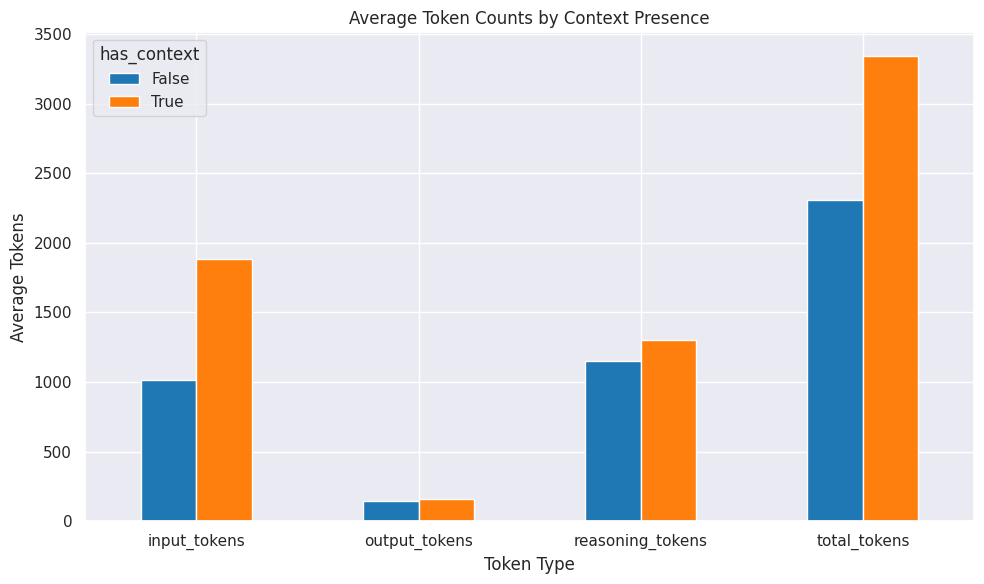

Average Token Counts by Context Presence: 

              input_tokens  output_tokens  reasoning_tokens  total_tokens  \
has_context                                                                
False             1013.51         143.39           1154.10       2311.00   
True              1887.41         155.02           1304.13       3346.56   

             input_tokens_std  output_tokens_std  reasoning_tokens_std  \
has_context                                                              
False                  546.55              22.76                688.41   
True                  1244.59              23.08                709.33   

             total_tokens_std  
has_context                    
False                  889.68  
True                  1364.37  


In [12]:
tokens = ["input_tokens", "output_tokens", "reasoning_tokens", "total_tokens"]

# Visualizing average token counts by context presence
sns.set_theme(palette="colorblind")

responses_df.groupby("has_context")[tokens].mean().T.plot.bar(
    figsize=(10, 6),
    title="Average Token Counts by Context Presence",
    ylabel="Average Tokens",
    xlabel="Token Type",
    rot=0,
    color=["#1f77b4", "#ff7f0e"],
    legend=["Without Context", "With Context"]
)
plt.tight_layout()
plt.show()

# Calculate and display mean and standard deviation token counts by context presence
avg_tokens = responses_df.groupby("has_context")[tokens].mean()
avg_tokens_std = responses_df.groupby("has_context")[tokens].std()
avg_tokens = avg_tokens.join(avg_tokens_std, rsuffix="_std")
print(f"Average Token Counts by Context Presence: \n\n {avg_tokens.round(2)}")

In [13]:
### --- Statistical Testing for Token Counts ---

# List of token types to perform the significance test on
token_types_to_test = ['output_tokens', 'input_tokens', 'reasoning_tokens', 'total_tokens']

print("--- Mann-Whitney U Tests for Different Token Types ---")

for token_type in token_types_to_test:
    # Separate the data into two groups for the current token type
    tokens_with_context = responses_df[responses_df['has_context'] == True][token_type]
    tokens_without_context = responses_df[responses_df['has_context'] == False][token_type]

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(tokens_with_context, tokens_without_context, alternative='two-sided')

    # Print and interpret the results for the current token type
    print(f"\n--- Results for: {token_type} ---")
    print(f"U Statistic: {stat:.2f}")
    print(f"P-value: {p_value:.4f}")

    # Interpretation
    alpha = 0.05
    if p_value < alpha:
        print(f"The difference in {token_type} between the 'with context' and 'without context' conditions is statistically significant.")
    else:
        print(f"There is no statistically significant difference in {token_type} between the conditions.")

    # Report the means
    print(f"Mean (With Context): {tokens_with_context.mean():.2f}")
    print(f"Mean (Without Context): {tokens_without_context.mean():.2f}")

--- Mann-Whitney U Tests for Different Token Types ---

--- Results for: output_tokens ---
U Statistic: 2392.50
P-value: 0.0065
The difference in output_tokens between the 'with context' and 'without context' conditions is statistically significant.
Mean (With Context): 155.02
Mean (Without Context): 143.39

--- Results for: input_tokens ---
U Statistic: 2929.00
P-value: 0.0000
The difference in input_tokens between the 'with context' and 'without context' conditions is statistically significant.
Mean (With Context): 1887.41
Mean (Without Context): 1013.51

--- Results for: reasoning_tokens ---
U Statistic: 2142.50
P-value: 0.1490
There is no statistically significant difference in reasoning_tokens between the conditions.
Mean (With Context): 1304.13
Mean (Without Context): 1154.10

--- Results for: total_tokens ---
U Statistic: 2778.00
P-value: 0.0000
The difference in total_tokens between the 'with context' and 'without context' conditions is statistically significant.
Mean (With Con

###  1. Dataset Loading & Preparation

In [14]:
### --- Reading the data ---
df_raw = pd.read_csv('../data/evaluation_results.csv')

### --- Restructuring the DataFrame to long format ---
metrics = ['accuracy', "clarity", "relevance", "completeness"]
conditions = ["with_context", "without_context"]

# Converting the dataset to long format
long_rows = []
for _, row in df_raw.iterrows():
    for cond in conditions:
        long_rows.append({
            "item_index": row.item_index,
            "condition": cond,
            **{m: row[f"{cond}_{m}"] for m in metrics},
            "overall": sum(row[f"{cond}_{m}"] for m in metrics)/len(metrics),
            "preference": row.preference_actual
        })

# Save the long format DataFrame
df = pd.DataFrame(long_rows)

# Creating a label mapping for conditions and better plotting
label_map = {
    "with_context": "Image & Context",
    "without_context": "Image-only",
}
df["condition_label"] = df["condition"].map(label_map)

### 2. Addressing Research Questions

#### 2.1 Do context-enhanced interpretations score higher on quality dimensions?

To answer this question, a paired statistical tests (e.g., paired t-test or Wilcoxon signed-rank if non-normal) on per-item differences was conducted to assess whether context yields significant improvements.

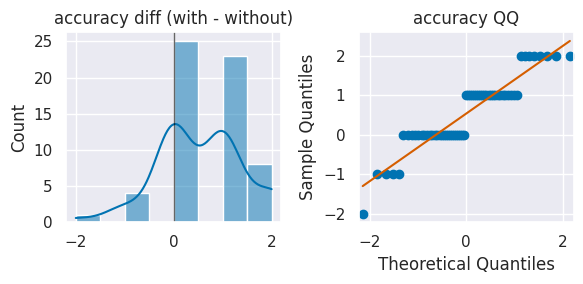

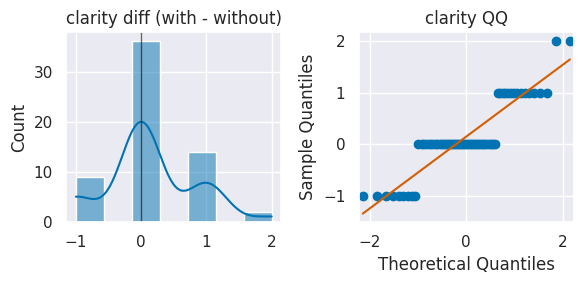

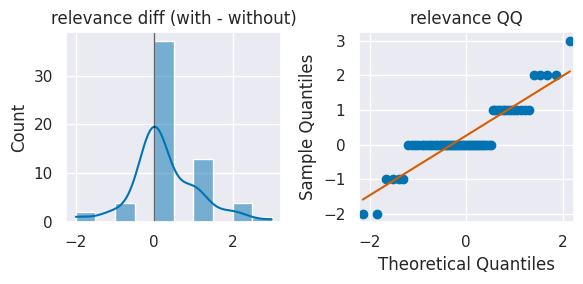

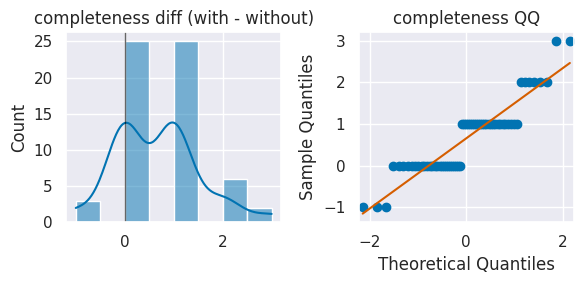

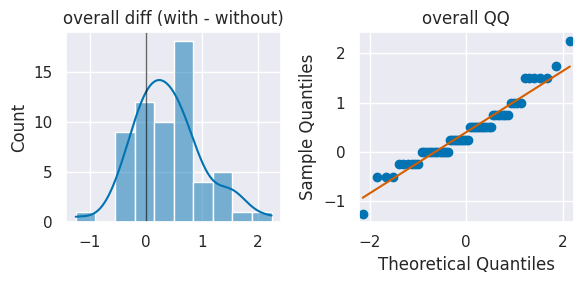

         metric  n_pairs  mean_diff  std_diff  shapiro_p_rounded
0      accuracy       61   0.540984  0.867444            0.00002
1       clarity       61   0.147541  0.703232            0.00000
2     relevance       61   0.262295  0.873721            0.00000
3  completeness       61   0.655738  0.854113            0.00001
4       overall       61   0.401639  0.626296            0.02332


In [15]:
### --- Plotting the distribution of differences & QQ plot ---
q_dims = metrics + ["overall"]

shapiro_rows = []
for q in q_dims:
    wide_q = df.pivot(index="item_index", columns="condition", values=q)
    diff = wide_q["with_context"] - wide_q["without_context"]
    diff_clean = diff.dropna()
    
    # Prepare figure
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    sns.histplot(diff_clean, kde=True, ax=axes[0])
    axes[0].set_title(f"{q} diff (with - without)")
    axes[0].axvline(0, color="black", lw=1, alpha=0.6)
    sm.qqplot(diff_clean, line="s", ax=axes[1])
    axes[1].set_title(f"{q} QQ")
    plt.tight_layout()
    plt.show()
    
    # Shapiro test (needs at least 3 values; meaningful if n >= 8)
    if len(diff_clean) >= 3:
        p = shapiro(diff_clean).pvalue
    else:
        p = np.nan
    shapiro_rows.append({
        "metric": q,
        "n_pairs": len(diff_clean),
        "mean_diff": diff_clean.mean(),
        "std_diff": diff_clean.std(ddof=1),
        "shapiro_p": p
    })

shapiro_df = pd.DataFrame(shapiro_rows)
shapiro_df["shapiro_p_rounded"] = shapiro_df["shapiro_p"].round(5)
print(shapiro_df[["metric","n_pairs","mean_diff","std_diff","shapiro_p_rounded"]])

Inspecting the distribution of differences histograms and the QQ plots, it is apparent that we are dealing with non-normally distributed data. This is also supported by the results from Shapiro-Wilk test which indicate strong-moderate evidence of non-normality. Therefore, non-parametric test is required to evaluate whether the two conditions differ on the quality of the chart interpretations.

In [16]:
### --- Statistical Tests for Differences in Quality Dimensions ---

# Performing Wilcoxon signed-rank test for each quality dimension + overall
rows = []
for q in q_dims:
    w = df.pivot(index="item_index", columns="condition", values=q)[["without_context","with_context"]]
    if w.empty: 
        continue
    diff = w["with_context"] - w["without_context"]

    # Wilcoxon signed-rank test (two-sided)
    w_stat, p_w = wilcoxon(diff)

    # Effect sizes
    pos = (diff > 0).sum()
    neg = (diff < 0).sum()
    n_eff = pos + neg
    r_rb = (pos - neg) / n_eff if n_eff else float("nan")  # rank-biserial
    # r from z (signed by mean diff), using normal approx from two-sided p
    z = norm.isf(p_w / 2.0) if p_w > 0 else float("inf")
    r_from_z = (z * (1 if diff.mean() >= 0 else -1)) / (n_eff ** 0.5) if n_eff else float("nan")

    # Quartiles and display ranges [Q1, Q3] - computed on the same paired subset
    q1_w, q3_w = w["with_context"].quantile([0.25, 0.75])
    q1_wo, q3_wo = w["without_context"].quantile([0.25, 0.75])
    q1_d, q3_d = diff.quantile([0.25, 0.75])

    rows.append({
        "metric": q,
        "n": len(w),
        "mean_with": w["with_context"].mean(),
        "mean_without": w["without_context"].mean(),
        "mean_diff": diff.mean(),
        "median_with": w["with_context"].median(),
        "median_without": w["without_context"].median(),
        "median_diff": diff.median(),
        "with_Q1_Q3": f"[{q1_w:.2f}, {q3_w:.2f}]",
        "without_Q1_Q3": f"[{q1_wo:.2f}, {q3_wo:.2f}]",
        "diff_Q1_Q3": f"[{q1_d:.2f}, {q3_d:.2f}]",
        "w_stat": w_stat,
        "wilcoxon_p": p_w,
        "rank_biserial": r_rb,
        "r_from_z": r_from_z,
    })

stats_df = pd.DataFrame(rows).round({
    "mean_with":3, "mean_without":3, "mean_diff":3,
    "median_with":3, "median_without":3, "median_diff":3,
    "w_stat":3, "wilcoxon_p":4, "rank_biserial":3, "r_from_z":3
})

print(stats_df)

         metric   n  mean_with  mean_without  mean_diff  median_with  \
0      accuracy  61      6.590         6.049      0.541         7.00   
1       clarity  61      6.623         6.475      0.148         7.00   
2     relevance  61      6.820         6.557      0.262         7.00   
3  completeness  61      6.803         6.148      0.656         7.00   
4       overall  61      6.709         6.307      0.402         6.75   

   median_without  median_diff    with_Q1_Q3 without_Q1_Q3    diff_Q1_Q3  \
0             6.0         1.00  [6.00, 7.00]  [5.00, 7.00]  [0.00, 1.00]   
1             7.0         0.00  [6.00, 7.00]  [6.00, 7.00]  [0.00, 1.00]   
2             7.0         0.00  [7.00, 7.00]  [6.00, 7.00]  [0.00, 1.00]   
3             6.0         1.00  [7.00, 7.00]  [6.00, 7.00]  [0.00, 1.00]   
4             6.5         0.25  [6.50, 7.00]  [6.00, 6.75]  [0.00, 0.75]   

   w_stat  wilcoxon_p  rank_biserial  r_from_z  
0    88.0      0.0000          0.722     0.678  
1   108.0   

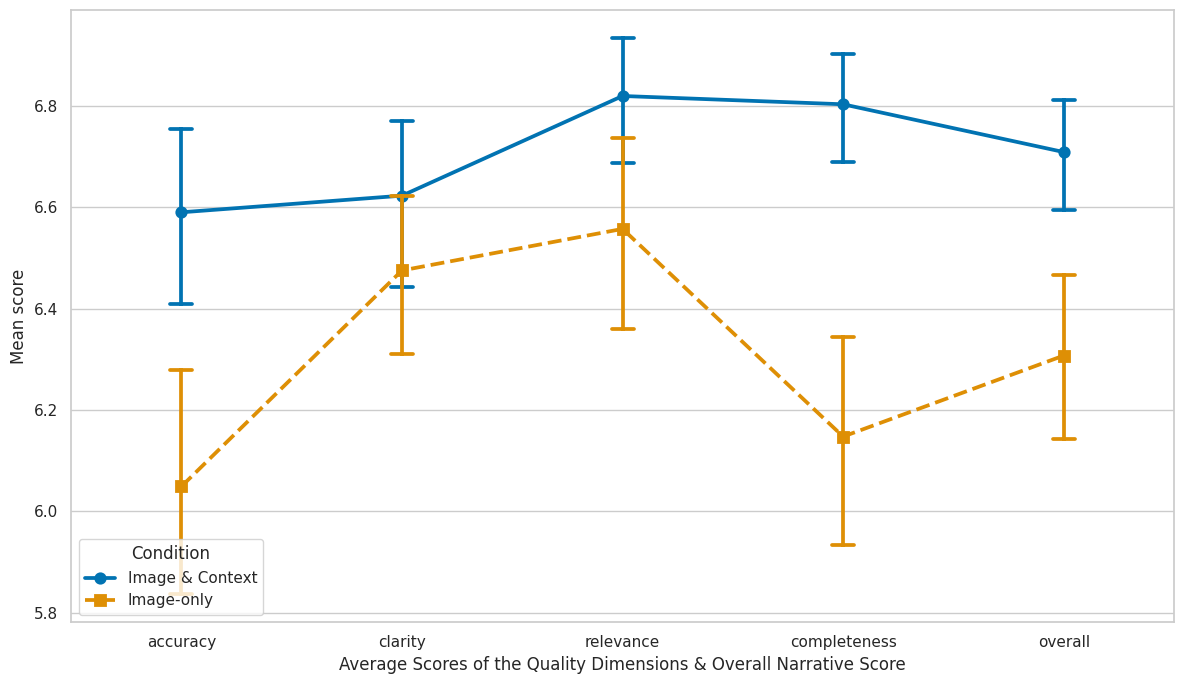

In [30]:
### --- Visualizing the Quality Dimensions mean scores ---

sns.set_theme(style="whitegrid", palette="colorblind")

mean_long = df.melt(id_vars=["condition_label"], value_vars=q_dims,
                    var_name="q_dims", value_name="score")

plt.figure(figsize=(12,7))
sns.pointplot(data=mean_long, x="q_dims", y="score", hue="condition_label", markers =["o", "s"], linestyles=["-", "--"], errorbar=('ci', 95), capsize=.1)
plt.ylabel("Mean score")
plt.xlabel("Average Scores of the Quality Dimensions & Overall Narrative Score")
plt.legend(title="Condition", loc='lower left')
plt.tight_layout()

### 2.2 Investigating overall preference between conditions

/tmp/ipykernel_28149/2692332609.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


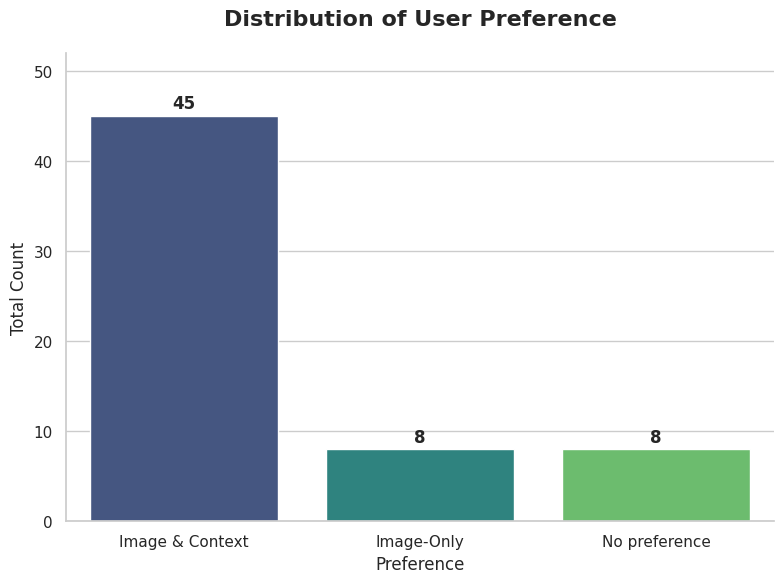


'Image & Context' was preferred 45 times.
'Image-Only' was preferred 8 times.
There was 'No preference' 8 times.


In [36]:
### --- Visualizing the Preference Distribution (Enhanced) ---

# Prepare the data by getting one preference per item
preference_df = df.drop_duplicates("item_index").copy() # Use .copy() to avoid SettingWithCopyWarning

# Rename categories for clarity in the plot
preference_df["preference"] = preference_df["preference"].replace({
    "with_context": "Image & Context",
    "without_context": "Image-Only",
    "equal": "No preference"
})

# --- Create the Plot ---
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")

# Create the countplot. Note we removed the redundant 'hue' parameter.
ax = sns.countplot(
    data=preference_df,
    x="preference",
    order=["Image & Context", "Image-Only", "No preference"],
    palette="viridis" # Using a different color palette
)

# --- Add Data Labels on Top of Each Bar ---
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',           # The text to display (the count)
                (p.get_x() + p.get_width() / 2., p.get_height()), # The (x,y) position
                ha='center', va='center',           # Center alignment
                xytext=(0, 9),                      # Offset the text above the bar
                textcoords='offset points',
                fontsize=12,
                fontweight='bold')

# --- Refine Titles and Labels ---
ax.set_title("Distribution of User Preference", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("Preference", fontsize=12)
ax.set_ylabel("Total Count", fontsize=12)
ax.set_ylim(0, ax.get_ylim()[1] * 1.1) # Add some space at the top for the labels

# Clean up the plot
sns.despine()
plt.tight_layout()
plt.show()

# The original print statements are still useful
counts = preference_df['preference'].value_counts()
print(f"\n'Image & Context' was preferred {counts.get('Image & Context', 0)} times.")
print(f"'Image-Only' was preferred {counts.get('Image-Only', 0)} times.")
print(f"There was 'No preference' {counts.get('No preference', 0)} times.")

In [19]:
### --- Statistical Test for Preferences ---
# Get the counts for the two main preference categories
with_context_prefs = counts.get('with_context', 0)
without_context_prefs = counts.get('without_context', 0)

# The total number of trials is the sum of preferences, excluding 'equal'
total_prefs = with_context_prefs + without_context_prefs

# Perform the two-sided binomial test.
# We test if the number of 'with_context' preferences (with_context_prefs)
# is significantly different from what we'd expect by chance (p=0.5).
result = binomtest(k=with_context_prefs, n=total_prefs, p=0.5)

print("\n--- Binomial Test for Preference Data ---")
print(f"Total preferences stated (excluding 'equal'): {total_prefs}")
print(f"Observed 'Image & Context' preferences: {with_context_prefs}")
print(f"P-value: {result.pvalue:.4f}")

# Interpretation
alpha = 0.05
if result.pvalue < alpha:
    print("\nThe observed preference for one condition over the other is statistically significant.")
else:
    print("\nThere is no statistically significant preference for one condition over the other.")


--- Binomial Test for Preference Data ---
Total preferences stated (excluding 'equal'): 53
Observed 'Image & Context' preferences: 45
P-value: 0.0000

The observed preference for one condition over the other is statistically significant.


### 2.3 Quality Dimensions Correlations

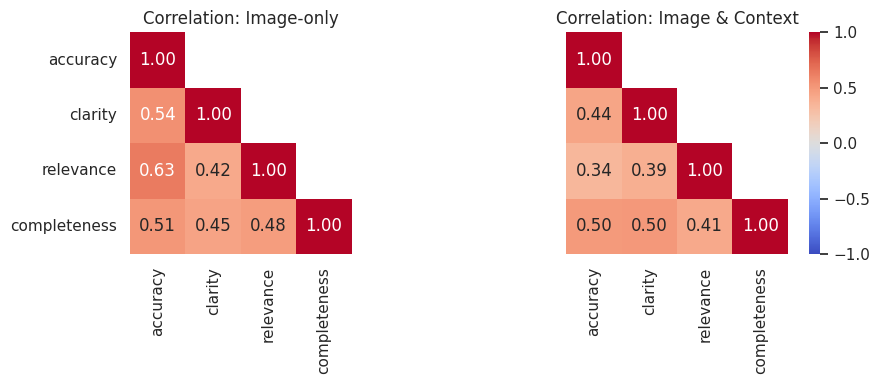

In [ ]:
### --- Visualizing the Correlation Matrix ---
# Plotting the correlation matrix for each condition
conds = ["without_context","with_context"]

with sns.axes_style("white"):
    fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)
    for ax, cond in zip(axes, conds):
        sub = df[df["condition"] == cond][metrics]
        corr = sub.corr()
        mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
        sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap="coolwarm",
                    annot=True, fmt=".2f", square=True, cbar=(cond=="with_context"), ax=ax)
        ax.set_title(f"Correlation: {label_map[cond]}")
    plt.tight_layout()

### 3. Error Analysis

This section presents a small set of representative chart–interpretation pairs noted during evaluation. The aim is to illustrate typical successes and failure modes; for a full quantitative and qualitative breakdown, see the Results (Error Analysis) section.

Overall pattern:
- Adding textual context generally improved grounding: interpretations more often referenced the correct entities, units, and chart semantics.
- However, context sometimes prompted the model to introduce extraneous or speculative details from the surrounding text. While occasionally helpful, this often reduced clarity and made the narrative harder to follow.

Condition-specific patterns:
- Image-only:
  - Weaker grounding and less detail about chart conventions.
  - Occasional misinterpretation of domain-specific abbreviations/acronyms, leading to incorrect claims.
- Image & Context:
  - Better grounded descriptions overall.
  - At times, over-interpretation by carrying in details not strictly derivable from the image.

Less frequent issues:
- Omissions of relevant chart elements or steps (e.g., not mentioning all series, axes, or key transformations).
- Inconsistent phrasing that obscured the main takeaway even when facts were otherwise correct.

Below, we include example items that exhibit these patterns; they are illustrative rather than exhaustive. For deeper analysis and statistics, refer to the Results section.

In [ ]:
### --- Loading the Images & Responses ---
# Helper functions
img_df = pd.read_csv('../data/evaluation_ready.csv')

# Encode image_path_1 -> data URI (one per row)
def to_data_uri(p):
    if pd.isna(p): 
        return None
    p = Path(str(p))
    if not p.is_file():
        print(f"Missing image: {p}")
        return None
    mime = mimetypes.guess_type(p.name)[0] or "image/png"
    b64 = base64.b64encode(p.read_bytes()).decode("ascii")
    return f"data:{mime};base64,{b64}"

img_df["image_src"] = img_df["image_path_1"].apply(to_data_uri)

good_interpretations = [5, 11, 32]
contextual_grounding = [10, 13, 15]
extra_detail = [6, 22, 29, 45]
false_claims = [12, 47, 58]
large_differences = [51, 55]
omissions = [0, 31]

items = good_interpretations + extra_detail + false_claims + large_differences + omissions + contextual_grounding

def show_card(row, img_width=420):
    esc = lambda x: html.escape("" if pd.isna(x) else str(x))
    img_src = row.get("image_src") or row.get("image_path_1")  # do not escape src
    display(HTML(f"""
    <div style="display:grid; grid-template-columns:{img_width}px 1fr 1fr; gap:12px; margin:10px 0; padding:12px; border:1px solid #e5e7eb; border-radius:8px; font-family:system-ui, sans-serif;">
      <div><img src="{img_src}" style="max-width:100%; height:auto; border:1px solid #eee;"></div>
      <div><div style="font-weight:600; margin-bottom:6px;">Image & Context</div>
           <div style="white-space:pre-wrap; line-height:1.4;">{esc(row['with_context'])}</div></div>
      <div><div style="font-weight:600; margin-bottom:6px;">Image-only</div>
           <div style="white-space:pre-wrap; line-height:1.4;">{esc(row['without_context'])}</div></div>
    </div>
    """))

#### Examples of good interpretations across both conditions


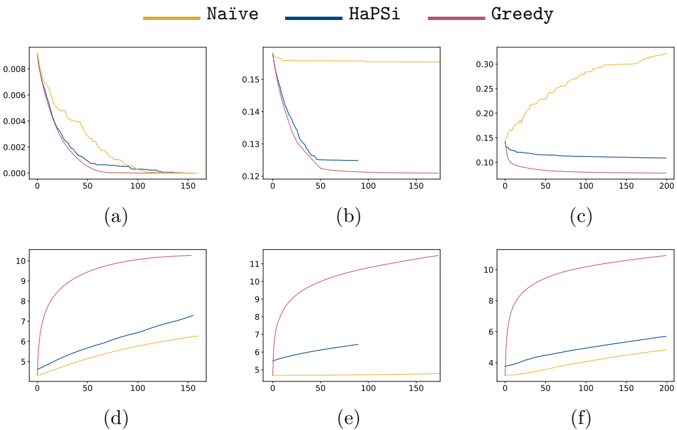


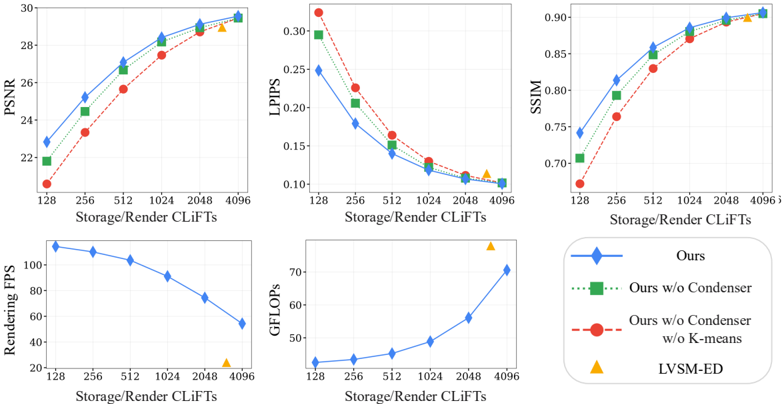


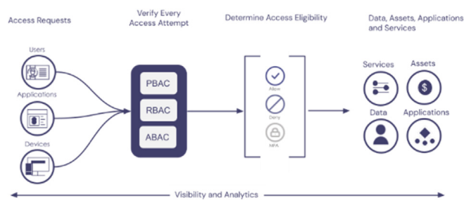

In [ ]:
### --- Good Interpretations in Both Conditions ---
for _, r in img_df.loc[good_interpretations].iterrows():
    show_card(r)

#### Examples of Interpretations having extra detail from context


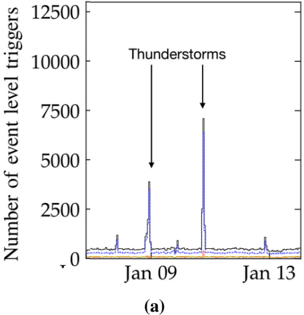


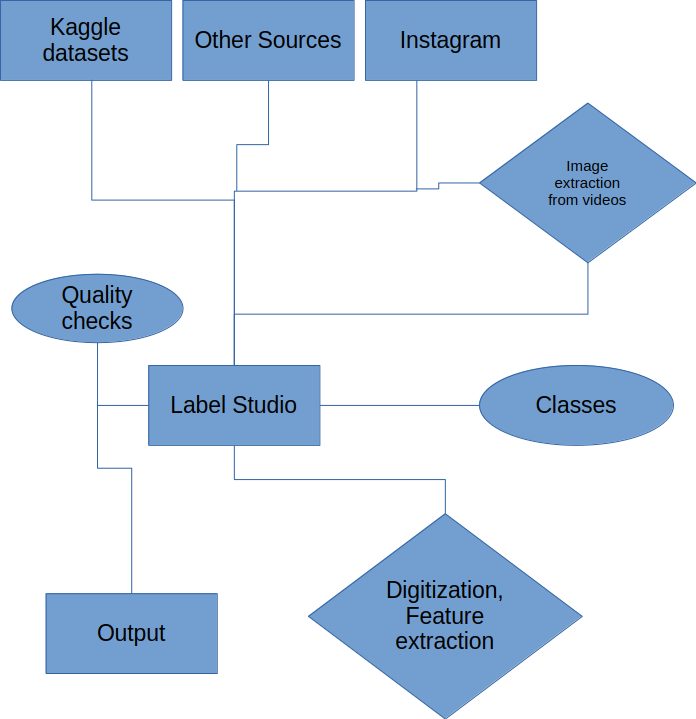


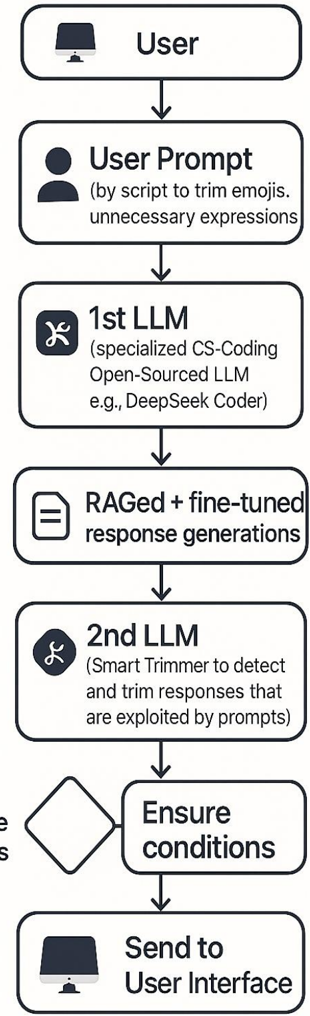


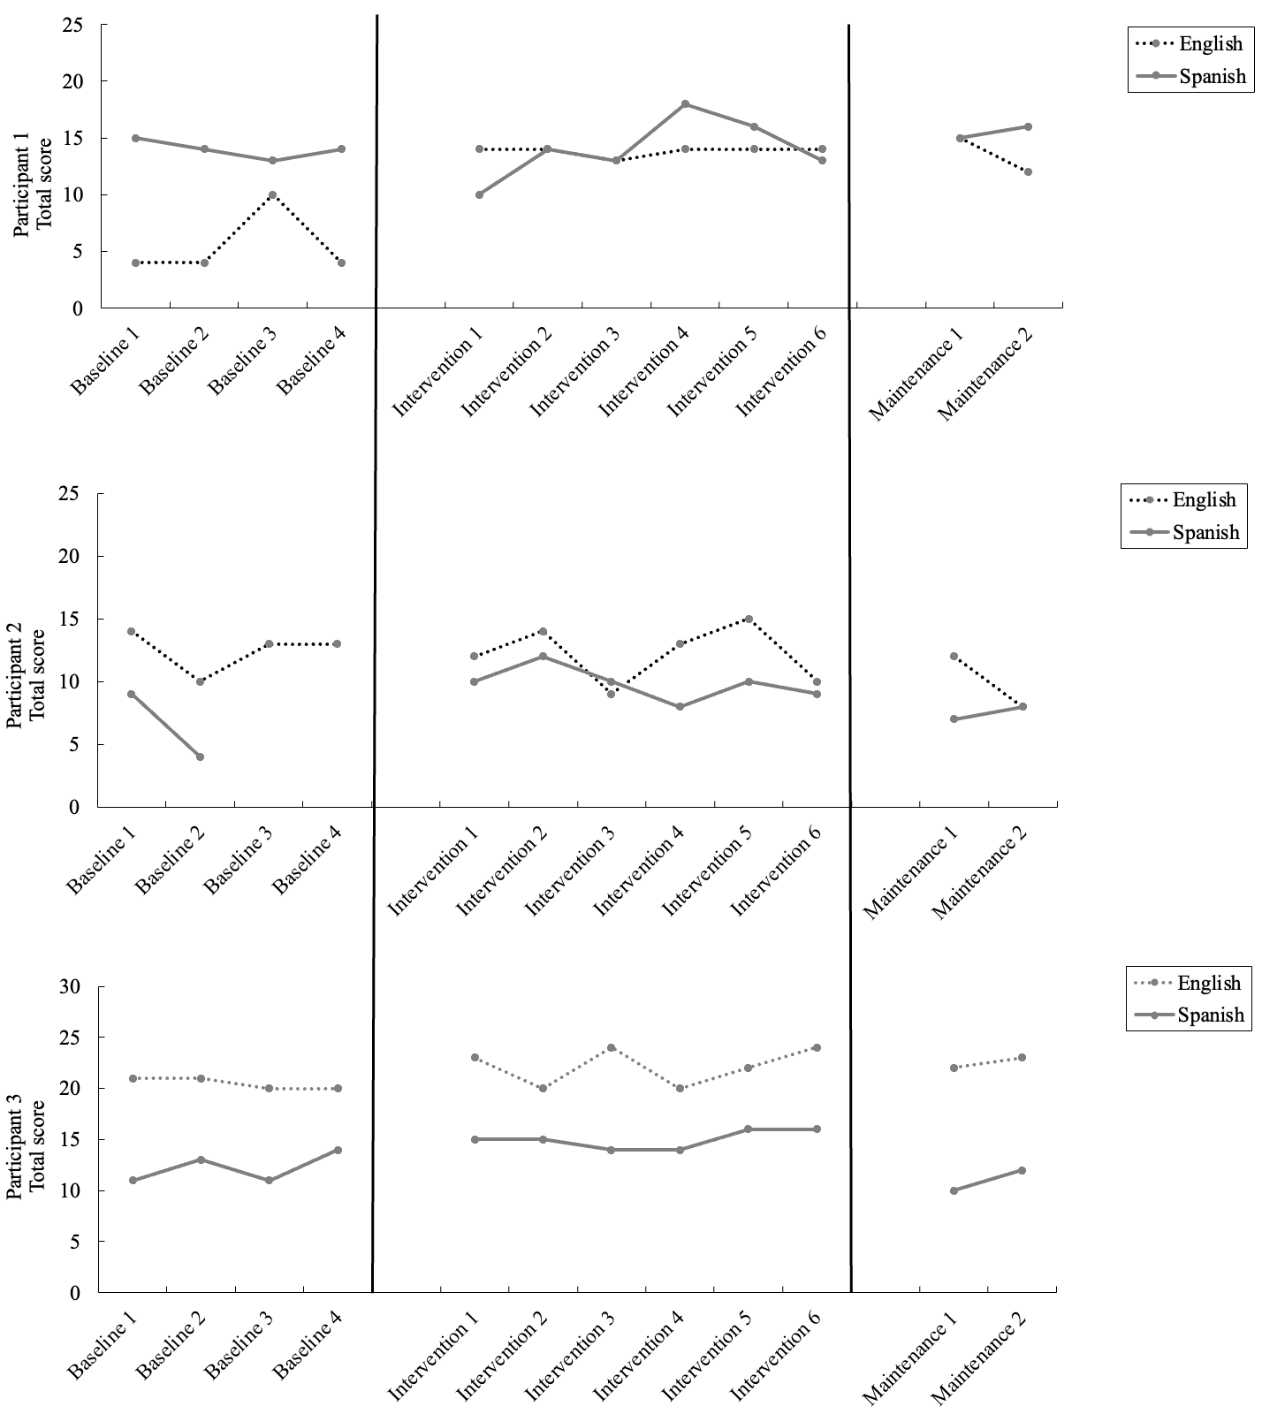

In [ ]:
### --- Chart & Chart interpretations that include extra detail underivable from the context ---
for _, r in img_df.loc[extra_detail].iterrows():
    show_card(r)

#### Examples of the model making false claims


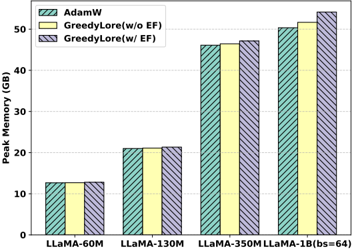


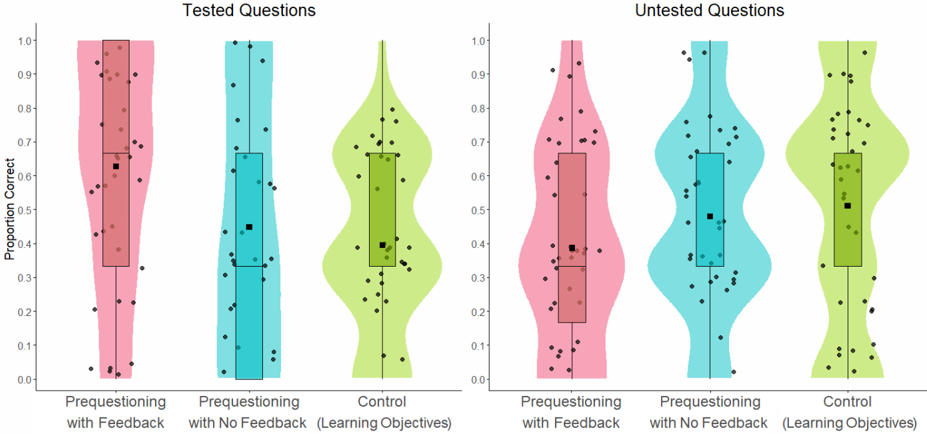


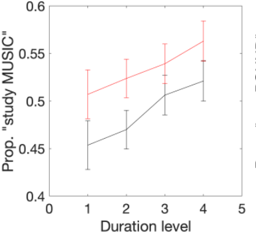

In [ ]:
### --- Chart & Chart interpretations where the some claims are wrong ---
for _, r in img_df.loc[false_claims].iterrows():
    show_card(r)

#### Examples where the generated text's evaluation scores between conditions had large differences


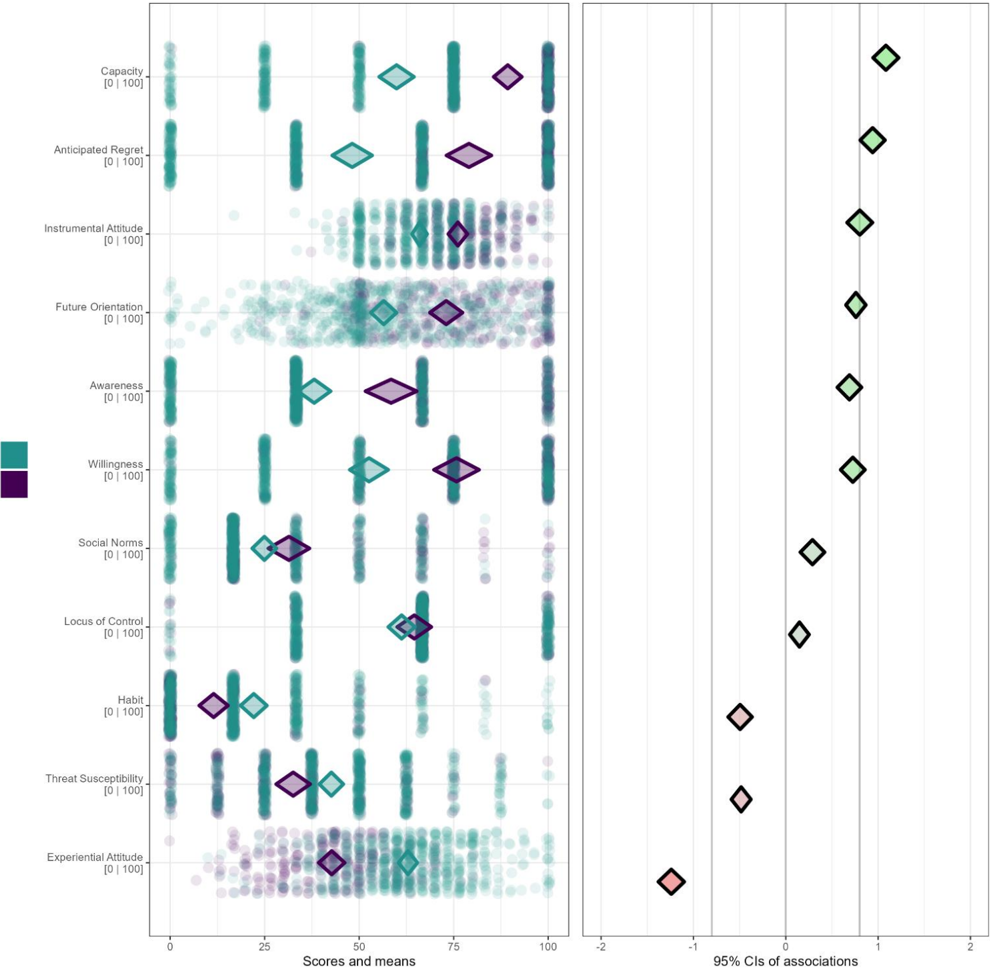


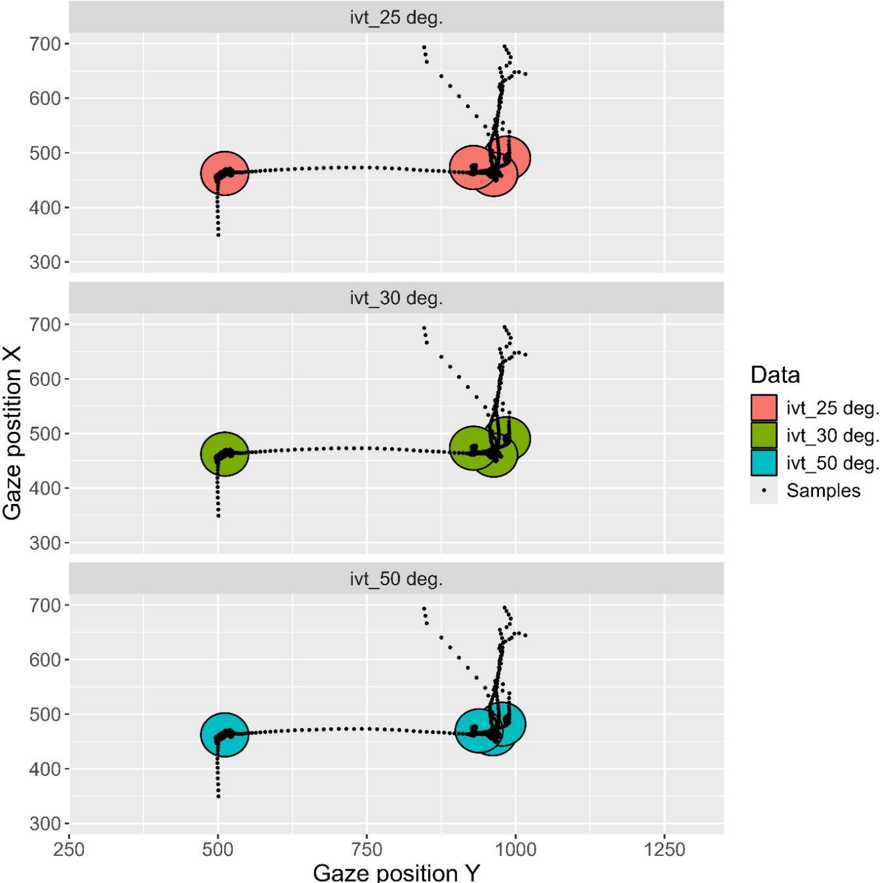

In [ ]:
### --- Chart & Chart interpretations that had a large difference in scores between conditions ---
for _, r in img_df.loc[large_differences].iterrows():
    show_card(r)

### Examples of cases where crucial information was omitted from the interpretation.


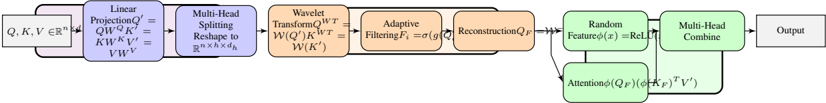


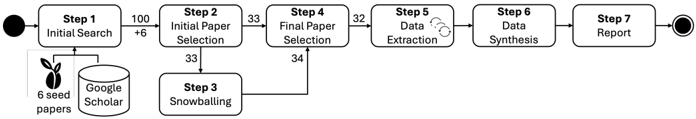

In [ ]:
### --- Chart & Chart interpretations where crucial information was ommitted ---
for _, r in img_df.loc[omissions].iterrows():
    show_card(r)

#### Examples where clear contextual grounding is showcased


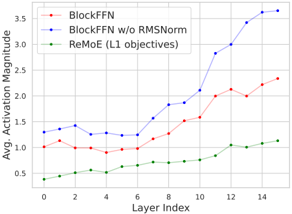


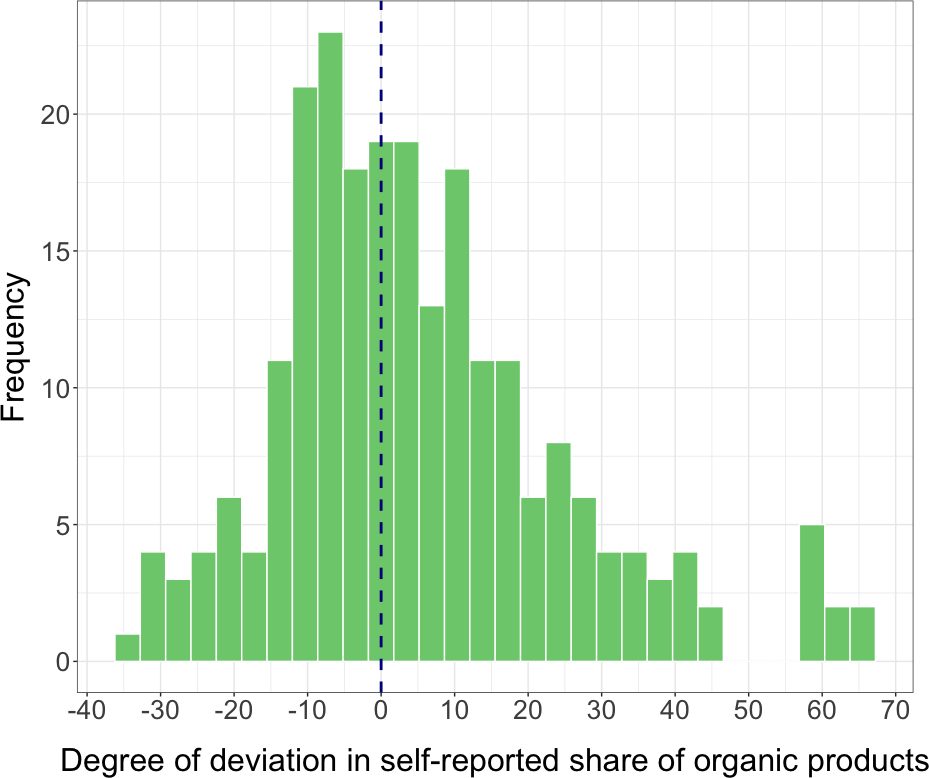


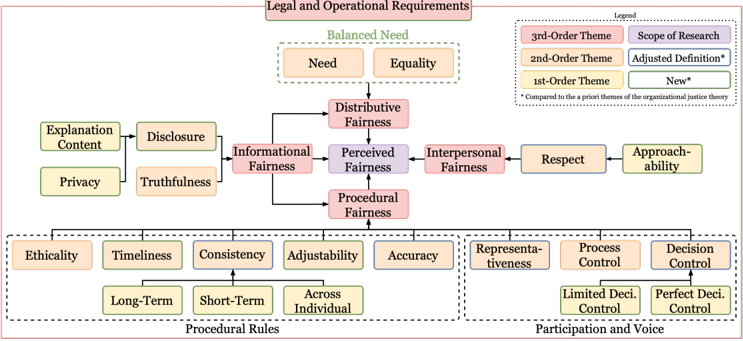

In [ ]:
### --- Chart & Chart interpretations where a clear contextual grounding is present ---
for _, r in img_df.loc[contextual_grounding].iterrows():
    show_card(r)